
=== Running backtest for sector: AI_CHIPS ===
Downloaded 10 tickers, 667 rows.
Top pairs by p-value:
      s1    s2    pvalue
0  NVDA   TSM  0.077260
1  LRCX    MU  0.086738
2    MU  QCOM  0.090078

Summary for sector: AI_CHIPS
    Pair   CAGR  Sharpe (approx)  Max Drawdown  Trades  Ann. Turnover (units)  Total PnL ($)  Total PnL (%)
 MU-QCOM 52.38%          159.72%       -26.45%      19                  25.06       4,098.01        204.90%
NVDA-TSM 38.12%          139.57%       -17.64%      27                  37.57       2,701.78        135.09%
 LRCX-MU -0.22%           -0.95%       -37.65%      21                  22.13         -11.70         -0.58%


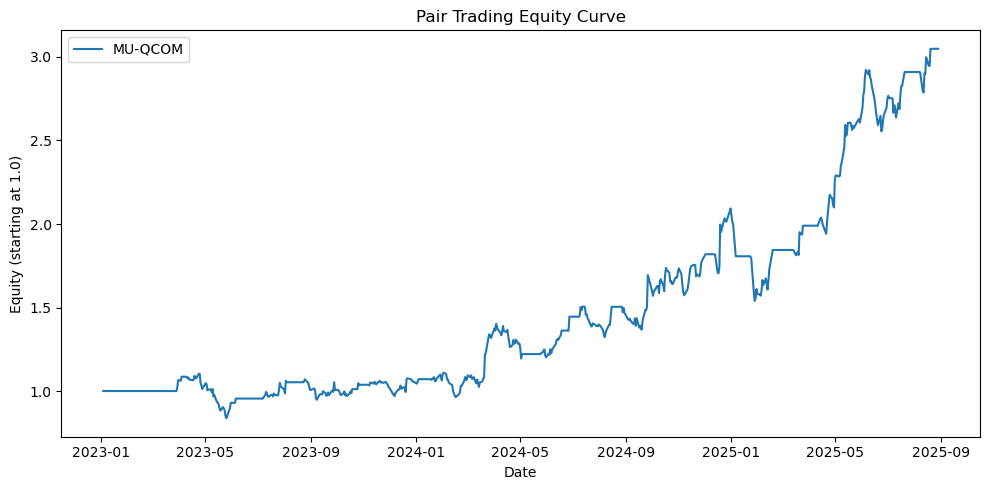

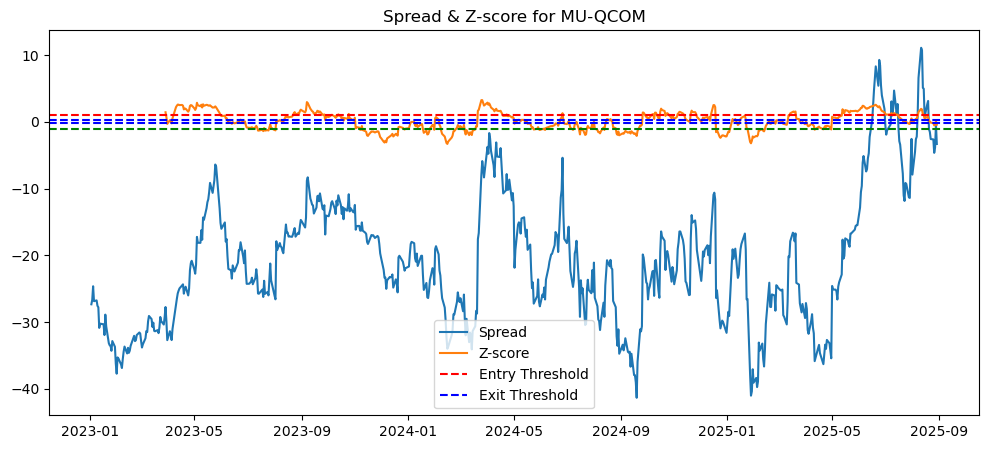


=== Running backtest for sector: CONSUMER_STAPLES ===
Downloaded 10 tickers, 667 rows.
Top pairs by p-value:
      s1   s2    pvalue
0   KDP   KO  0.125860
1  MDLZ  WMT  0.129064
2   KDP  WMT  0.147741

Summary for sector: CONSUMER_STAPLES
    Pair  CAGR  Sharpe (approx)  Max Drawdown  Trades  Ann. Turnover (units)  Total PnL ($)  Total PnL (%)
  KDP-KO 6.86%           41.37%       -17.76%      16                  12.38         384.09         19.20%
 KDP-WMT 4.66%           26.10%       -22.61%      18                  13.25         256.16         12.81%
MDLZ-WMT 2.89%           17.37%       -22.30%      16                  12.51         156.54          7.83%


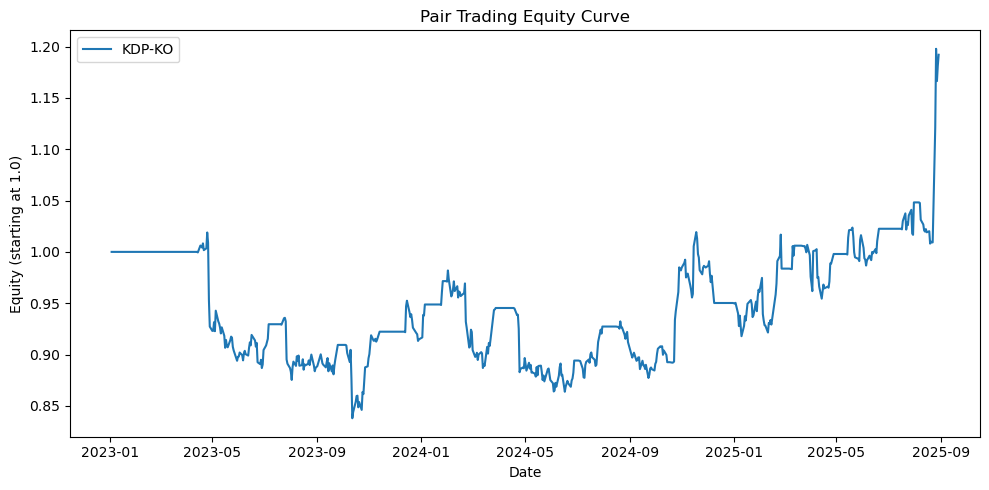

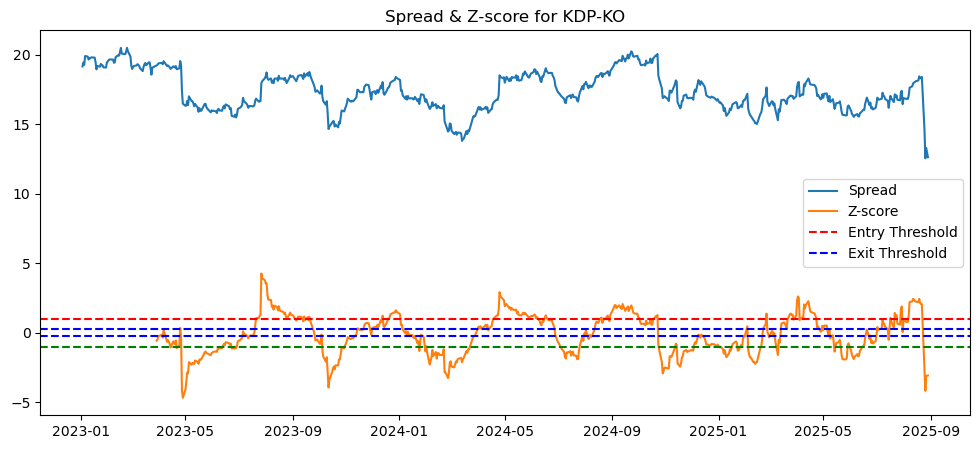


=== Running backtest for sector: EV ===


HTTP Error 404: 

1 Failed download:
['FSR']: YFTzMissingError('possibly delisted; no timezone found')


Downloaded 10 tickers, 0 rows.
Error running sector EV: 'pvalue'

=== Running backtest for sector: BIOPHARMA ===
Downloaded 10 tickers, 667 rows.
Top pairs by p-value:
      s1    s2    pvalue
0   PFE  REGN  0.008468
1  AMGN  VRTX  0.024722
2  BNTX  VRTX  0.027346

Summary for sector: BIOPHARMA
     Pair   CAGR  Sharpe (approx)  Max Drawdown  Trades  Ann. Turnover (units)  Total PnL ($)  Total PnL (%)
BNTX-VRTX 40.62%          114.37%       -23.27%      23                  17.24       2,930.28        146.51%
 PFE-REGN  7.58%           37.63%       -22.99%      21                  16.25         426.48         21.32%
AMGN-VRTX -3.94%          -18.78%       -24.95%      18                  16.12        -201.99        -10.10%


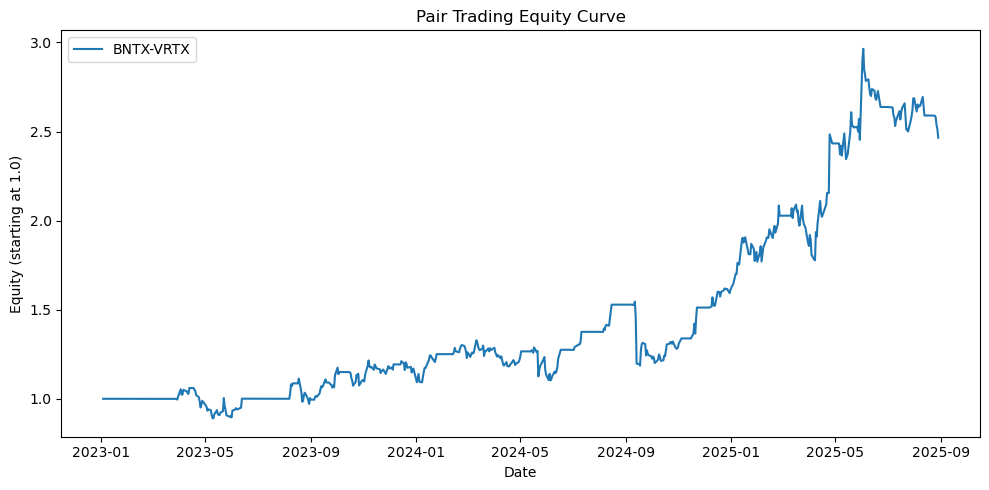

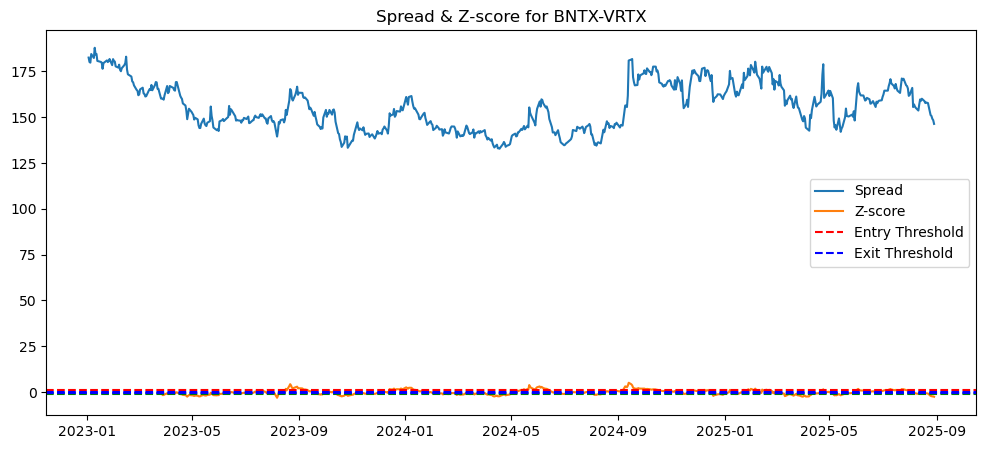


=== Running backtest for sector: CLOUD ===



1 Failed download:
['WORK']: YFTzMissingError('possibly delisted; no timezone found')


Downloaded 10 tickers, 0 rows.
Error running sector CLOUD: 'pvalue'

=== Running backtest for sector: ENERGY ===



1 Failed download:
['RDS.A']: YFTzMissingError('possibly delisted; no timezone found')


Downloaded 10 tickers, 0 rows.
Error running sector ENERGY: 'pvalue'

=== Best Pair per Sector ===
          Sector Best Pair  Total PnL ($)  Total PnL (%)   CAGR  Sharpe
        AI_CHIPS   MU-QCOM       4,098.01        204.90% 52.38% 159.72%
       BIOPHARMA BNTX-VRTX       2,930.28        146.51% 40.62% 114.37%
CONSUMER_STAPLES    KDP-KO         384.09         19.20%  6.86%  41.37%


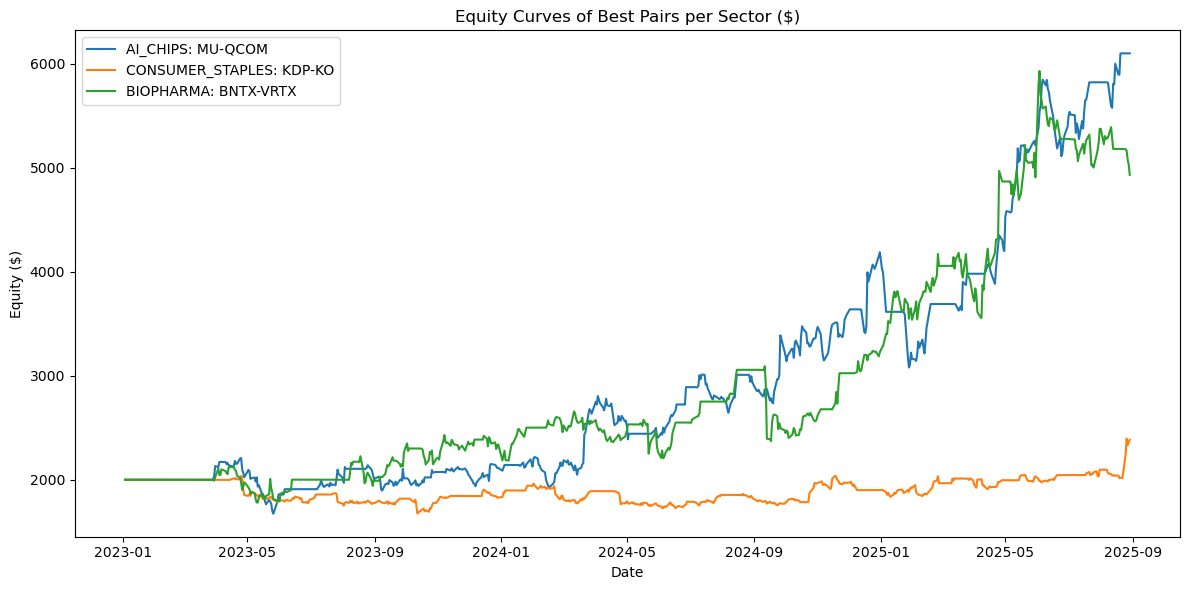

In [17]:
# -----------------------------
# Configuration
# -----------------------------
import itertools
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

START = "2023-01-01"
END = None
PVALUE_THRESHOLD = 0.05
TOP_N = 3
LOOKBACK = 60
ENTRY_Z = 1.0
EXIT_Z = 0.25
MAX_HOLD_DAYS = 40
COST_BPS = 5
INITIAL_CAPITAL = 2000.0

# -----------------------------
# Λίστες tickers ανά κλάδο
# -----------------------------
TICKERS_AI_CHIPS = ["NVDA", "AMD", "INTC", "TSM", "QCOM", "MU", "ASML", "AMAT", "LRCX", "KLAC"]
TICKERS_CONSUMER_STAPLES = ["KO", "PEP", "MCD", "SBUX", "COST", "WMT", "TGT", "MDLZ", "KDP", "HSY"]
TICKERS_EV = ["TSLA", "NIO", "LI", "XPEV", "BYDDF", "F", "GM", "RIVN", "LCID", "FSR"]
TICKERS_BIOPHARMA = ["PFE", "MRNA", "BNTX", "JNJ", "ABBV", "GILD", "AMGN", "REGN", "BIIB", "VRTX"]
TICKERS_CLOUD = ["MSFT", "ORCL", "CRM", "ADBE", "SNOW", "MDB", "NOW", "TEAM", "WORK", "INTU"]
TICKERS_ENERGY = ["XOM", "CVX", "BP", "RDS.A", "NEE", "FSLR", "ENPH", "TSLA", "BLDP", "PLUG"]

ALL_TICKER_GROUPS = {
    "AI_CHIPS": TICKERS_AI_CHIPS,
    "CONSUMER_STAPLES": TICKERS_CONSUMER_STAPLES,
    "EV": TICKERS_EV,
    "BIOPHARMA": TICKERS_BIOPHARMA,
    "CLOUD": TICKERS_CLOUD,
    "ENERGY": TICKERS_ENERGY
}

# -----------------------------
# Data Classes
# -----------------------------
@dataclass
class PairResult:
    s1: str
    s2: str
    pvalue: float

@dataclass
class BacktestReport:
    pair: Tuple[str, str]
    cagr: float
    sharpe: float
    max_dd: float
    trades: int
    ann_turnover: float
    equity: pd.Series
    trade_pnl: List[float]
    positions: pd.DataFrame

# -----------------------------
# Utilities
# -----------------------------
def download_prices(tickers: List[str], start: str, end: str | None) -> pd.DataFrame:
    data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data = data.dropna(how="all").ffill().dropna(how="any")
    return data

def hedge_ratio(y: pd.Series, x: pd.Series) -> float:
    x_ = sm.add_constant(x)
    model = sm.OLS(y, x_).fit()
    beta = model.params[x_.columns[1]]
    return float(beta)

def coint_screen(data: pd.DataFrame) -> pd.DataFrame:
    results: List[PairResult] = []
    for a, b in itertools.combinations(list(data.columns), 2):
        s1, s2 = data[a].dropna(), data[b].dropna()
        if len(s1) < LOOKBACK or len(s2) < LOOKBACK:
            continue
        s1, s2 = s1.align(s2, join="inner")
        if s1.std() == 0 or s2.std() == 0:
            continue
        score, pval, _ = sm.tsa.stattools.coint(s1, s2)
        results.append(PairResult(a, b, float(pval)))
    df = pd.DataFrame([r.__dict__ for r in results]).sort_values("pvalue").reset_index(drop=True)
    return df

def rolling_zscore(spread: pd.Series, lookback: int) -> pd.Series:
    mu = spread.rolling(lookback).mean()
    sd = spread.rolling(lookback).std(ddof=0)
    z = (spread - mu) / sd
    return z

def max_drawdown(equity: pd.Series) -> float:
    cummax = equity.cummax()
    dd = equity / cummax - 1.0
    return float(dd.min())

def annualize_return(r: pd.Series, periods_per_year: int = 252) -> float:
    if r.empty:
        return 0.0
    total = (1 + r).prod()
    years = len(r) / periods_per_year
    if years <= 0:
        return 0.0
    return float(total ** (1 / years) - 1)

def annualize_vol(r: pd.Series, periods_per_year: int = 252) -> float:
    return float(r.std(ddof=0) * math.sqrt(periods_per_year))

# -----------------------------
# Backtest Function
# -----------------------------
def backtest_pair(data: pd.DataFrame,
                  s1: str, s2: str,
                  lookback: int = LOOKBACK,
                  entry_z: float = ENTRY_Z,
                  exit_z: float = EXIT_Z,
                  max_hold_days: int = MAX_HOLD_DAYS,
                  cost_bps: float = COST_BPS) -> BacktestReport:

    px = data[[s1, s2]].dropna()
    y, x = px[s1], px[s2]
    beta = hedge_ratio(y, x)
    spread = y - beta * x
    z = rolling_zscore(spread, lookback)

    state = 0
    days_in_trade = 0
    pos_y = pd.Series(0.0, index=px.index)
    pos_x = pd.Series(0.0, index=px.index)

    for t in px.index:
        zt = z.loc[t]
        if state != 0:
            days_in_trade += 1
            if (abs(zt) <= exit_z) or (days_in_trade >= max_hold_days):
                state = 0
                days_in_trade = 0
        if state == 0 and np.isfinite(zt):
            if zt >= entry_z:
                state = -1
                days_in_trade = 0
            elif zt <= -entry_z:
                state = +1
                days_in_trade = 0
        if state == +1:
            pos_y.loc[t] = +1.0
            pos_x.loc[t] = -beta
        elif state == -1:
            pos_y.loc[t] = -1.0
            pos_x.loc[t] = +beta
        else:
            pos_y.loc[t] = 0.0
            pos_x.loc[t] = 0.0

    ret = px.pct_change().fillna(0.0)
    pos_y_lag = pos_y.shift(1).fillna(0.0)
    pos_x_lag = pos_x.shift(1).fillna(0.0)
    gross_ret = pos_y_lag * ret[s1] + pos_x_lag * ret[s2]

    ch_y = pos_y.diff().abs().fillna(abs(pos_y.iloc[0]))
    ch_x = pos_x.diff().abs().fillna(abs(pos_x.iloc[0]))
    cost = (ch_y + abs(beta) * ch_x) * (cost_bps / 10000.0)
    net_ret = gross_ret - cost
    equity = (1 + net_ret).cumprod()

    cagr = annualize_return(net_ret)
    vol = annualize_vol(net_ret)
    sharpe = (cagr / vol) if vol > 0 else 0.0
    mdd = max_drawdown(equity)
    trades = int(((pos_y.shift(1) == 0) & (pos_y != 0)).sum())
    ann_turnover = float((ch_y + abs(beta) * ch_x).sum() * (252 / len(px)))

    trade_pnl: List[float] = []
    current_pnl = 0.0
    in_trade = False
    for t in px.index:
        if pos_y.loc[t] != 0 or pos_x.loc[t] != 0:
            current_pnl += net_ret.loc[t]
            in_trade = True
        if in_trade and pos_y.loc[t] == 0 and pos_x.loc[t] == 0:
            trade_pnl.append(current_pnl)
            current_pnl = 0.0
            in_trade = False
    if in_trade:
        trade_pnl.append(current_pnl)

    positions = pd.DataFrame({"pos_y": pos_y, "pos_x": pos_x, "spread": spread, "zscore": z})

    return BacktestReport(
        pair=(s1, s2),
        cagr=cagr,
        sharpe=sharpe,
        max_dd=mdd,
        trades=trades,
        ann_turnover=ann_turnover,
        equity=equity,
        trade_pnl=trade_pnl,
        positions=positions
    )

# -----------------------------
# Pipeline
# -----------------------------
def run_pipeline(tickers: List[str], start: str, end: str | None,
                 pvalue_threshold: float, top_n: int):

    prices = download_prices(tickers, start, end)
    print(f"Downloaded {prices.shape[1]} tickers, {prices.shape[0]} rows.")

    screen_df = coint_screen(prices)
    if screen_df.empty:
        raise RuntimeError("No pairs passed the basic screening.")

    candidates = screen_df[screen_df["pvalue"] <= pvalue_threshold].copy()
    if candidates.empty:
        candidates = screen_df.head(top_n).copy()

    top = candidates.sort_values("pvalue").head(top_n).reset_index(drop=True)
    print("Top pairs by p-value:\n", top)

    reports: List[BacktestReport] = []
    for _, row in top.iterrows():
        rep = backtest_pair(prices, row.s1, row.s2)
        reports.append(rep)

    summary = pd.DataFrame({
        "Pair": [f"{r.pair[0]}-{r.pair[1]}" for r in reports],
        "CAGR": [r.cagr for r in reports],
        "Sharpe (approx)": [r.sharpe for r in reports],
        "Max Drawdown": [r.max_dd for r in reports],
        "Trades": [r.trades for r in reports],
        "Ann. Turnover (units)": [r.ann_turnover for r in reports],
        "Total PnL ($)": [INITIAL_CAPITAL*(r.equity.iloc[-1]-1) for r in reports],
        "Total PnL (%)": [r.equity.iloc[-1]-1 for r in reports]
    }).sort_values(["Sharpe (approx)", "CAGR"], ascending=[False, False]).reset_index(drop=True)

    return summary, reports

# -----------------------------
# Plot Functions
# -----------------------------
def plot_equity(report: BacktestReport):
    plt.figure(figsize=(10, 5))
    plt.plot(report.equity.index, report.equity.values, label=f"{report.pair[0]}-{report.pair[1]}")
    plt.title("Pair Trading Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity (starting at 1.0)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_spread_zscore(report: BacktestReport):
    df = report.positions
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df["spread"], label="Spread")
    plt.plot(df.index, df["zscore"], label="Z-score")
    plt.axhline(ENTRY_Z, color='red', linestyle='--', label='Entry Threshold')
    plt.axhline(-ENTRY_Z, color='green', linestyle='--')
    plt.axhline(EXIT_Z, color='blue', linestyle='--', label='Exit Threshold')
    plt.axhline(-EXIT_Z, color='blue', linestyle='--')
    plt.title(f"Spread & Z-score for {report.pair[0]}-{report.pair[1]}")
    plt.legend()
    plt.show()

# -----------------------------
# Τρέξιμο pipeline για κάθε κλάδο
# -----------------------------
all_summaries = {}
best_reports_per_sector = {}

for sector_name, tickers in ALL_TICKER_GROUPS.items():
    print(f"\n=== Running backtest for sector: {sector_name} ===")
    try:
        summary, reports = run_pipeline(tickers, START, END, PVALUE_THRESHOLD, TOP_N)
        all_summaries[sector_name] = summary

        best_report = max(reports, key=lambda r: r.sharpe)
        best_reports_per_sector[sector_name] = best_report

        print("\nSummary for sector:", sector_name)
        print(summary.to_string(index=False, float_format=lambda x: f"{x:,.2%}" if abs(x)<5 else f"{x:,.2f}"))

        plot_equity(best_report)
        plot_spread_zscore(best_report)

    except Exception as e:
        print(f"Error running sector {sector_name}: {e}")

# -----------------------------
# Συγκεντρωτικό table με καλύτερο ζεύγος ανά κλάδο
# -----------------------------
summary_rows = []
for sector_name, report in best_reports_per_sector.items():
    pnl_dollars = INITIAL_CAPITAL*(report.equity.iloc[-1]-1)
    pnl_percent = report.equity.iloc[-1]-1
    summary_rows.append({
        "Sector": sector_name,
        "Best Pair": f"{report.pair[0]}-{report.pair[1]}",
        "Total PnL ($)": pnl_dollars,
        "Total PnL (%)": pnl_percent,
        "CAGR": report.cagr,
        "Sharpe": report.sharpe
    })

df_best_per_sector = pd.DataFrame(summary_rows)
df_best_per_sector = df_best_per_sector.sort_values("Total PnL ($)", ascending=False).reset_index(drop=True)

print("\n=== Best Pair per Sector ===")
print(df_best_per_sector.to_string(index=False, float_format=lambda x: f"{x:,.2%}" if abs(x)<5 else f"{x:,.2f}"))

# -----------------------------
# Οπτικοποίηση όλων των equity curves των καλύτερων ζευγών
# -----------------------------
plt.figure(figsize=(12,6))
for sector_name, report in best_reports_per_sector.items():
    plt.plot(report.equity.index, INITIAL_CAPITAL*report.equity.values, label=f"{sector_name}: {report.pair[0]}-{report.pair[1]}")
plt.title("Equity Curves of Best Pairs per Sector ($)")
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# -----------------------------
# Εκτύπωση trade PnL για τα καλύτερα ζεύγη ανά κλάδο
# -----------------------------
for sector_name, report in best_reports_per_sector.items():
    print(f"\n=== Trade PnL for Best Pair in Sector: {sector_name} ({report.pair[0]}-{report.pair[1]}) ===")
    for i, pnl in enumerate(report.trade_pnl, start=1):
        pnl_dollars = pnl * INITIAL_CAPITAL
        pnl_percent = pnl
        print(f"Trade {i}: PnL = ${pnl_dollars:,.2f} ({pnl_percent:.2%})")



=== Trade PnL for Best Pair in Sector: AI_CHIPS (MU-QCOM) ===
Trade 1: PnL = $120.33 (6.02%)
Trade 2: PnL = $-289.69 (-14.48%)
Trade 3: PnL = $223.01 (11.15%)
Trade 4: PnL = $-114.67 (-5.73%)
Trade 5: PnL = $47.27 (2.36%)
Trade 6: PnL = $48.70 (2.44%)
Trade 7: PnL = $265.09 (13.25%)
Trade 8: PnL = $181.77 (9.09%)
Trade 9: PnL = $-1.58 (-0.08%)
Trade 10: PnL = $53.58 (2.68%)
Trade 11: PnL = $-144.54 (-7.23%)
Trade 12: PnL = $88.22 (4.41%)
Trade 13: PnL = $339.37 (16.97%)
Trade 14: PnL = $44.72 (2.24%)
Trade 15: PnL = $215.54 (10.78%)
Trade 16: PnL = $-63.57 (-3.18%)
Trade 17: PnL = $102.42 (5.12%)
Trade 18: PnL = $732.26 (36.61%)
Trade 19: PnL = $29.39 (1.47%)

=== Trade PnL for Best Pair in Sector: CONSUMER_STAPLES (KDP-KO) ===
Trade 1: PnL = $-169.58 (-8.48%)
Trade 2: PnL = $-72.37 (-3.62%)
Trade 3: PnL = $16.05 (0.80%)
Trade 4: PnL = $35.56 (1.78%)
Trade 5: PnL = $25.82 (1.29%)
Trade 6: PnL = $-52.27 (-2.61%)
Trade 7: PnL = $-133.21 (-6.66%)
Trade 8: PnL = $58.96 (2.95%)
Trade 9: Pn